In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json
from os.path import expanduser

In [2]:
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(EXPERIMENT_NAME)
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RESULTS_DIR = '/Users/darylwilding-mcbride/Downloads/results-P3856-3did'

In [3]:
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [4]:
FEATURES_DIR = "{}/features-3did".format(EXPERIMENT_DIR)
FEATURES_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)
# FEATURES_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(RESULTS_DIR, EXPERIMENT_NAME, RUN_NAME)

In [5]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### select a feature, or the stopping point

In [6]:
d = pd.read_pickle(FEATURES_FILE)
features_df = d['features_df']
features_df.reset_index(drop=True, inplace=True)

In [7]:
len(features_df)

2121

In [8]:
# select a random feature of the most intense
features_df.sort_values(by=['feature_intensity'], ascending=False, inplace=True)
features_df.head(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
432,432,79943
1166,1166,85299
1051,1051,86515


In [9]:
# select a random feature of the least intense
features_df.tail(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
1685,1685,9401
72,72,9706
681,681,8345


In [121]:
inspect_feature_id = 681

In [122]:
selected_feature = features_df[(features_df.feature_id == inspect_feature_id)].iloc[0]

In [123]:
selected_feature

mono_mz_lower                                                                     816.850898
mono_mz_upper                                                                     816.902932
scan_apex                                                                              350.0
scan_lower                                                                             326.0
scan_upper                                                                             376.0
rt_apex                                                                           1959.00772
rt_lower                                                                          1956.36036
rt_upper                                                                         1961.652703
intensity_without_saturation_correction                                                 8345
intensity_with_saturation_correction                                                    8345
mono_intensity_adjustment_outcome                                 mono

In [124]:
# all features from the same voxel
features_df[(features_df.voxel_id == selected_feature.voxel_id)].feature_id

681    681
Name: feature_id, dtype: int64

In [125]:
selected_feature.voxel_metadata_d

{'mz_lower': 816.786801998486,
 'mz_upper': 816.8873045110488,
 'scan_lower': 348,
 'scan_upper': 358,
 'rt_lower': 1955.4430737954922,
 'rt_upper': 1960.4430737954922,
 'mz_centroid': 816.8762095152453,
 'iso_mz_lower': 816.8501923607648,
 'iso_mz_upper': 816.9022266697257,
 'voxel_scan_midpoint': 353.0,
 'voxel_rt_midpoint': 1957.9430737954922,
 'frame_region_scan_lower': 313.0,
 'frame_region_scan_upper': 393.0,
 'summed_intensity': 33517,
 'point_count': 56}

In [126]:
segment_mz_lower = int(selected_feature.monoisotopic_mz / 20) * 20
segment_mz_upper = segment_mz_lower+20

In [127]:
summary_df = pd.read_pickle('{}/summary/summary-{}-{}.pkl'.format(FEATURES_DIR, segment_mz_lower, segment_mz_upper))

In [128]:
voxels = []
processed = set()
for p in selected_feature.isotopic_peaks:
    voxel_ids = set(p['voxel_ids_for_isotope'])
    voxel_ids = voxel_ids - processed
    for v in voxel_ids:
        voxel = summary_df[summary_df.voxel_id == int(v)].iloc[0]
        mz_bin = voxel.bin_key[0]
        scan_bin = voxel.bin_key[1]
        rt_bin = voxel.bin_key[2]
        voxels.append({'mz_lower':mz_bin.left, 'mz_upper':mz_bin.right, 'scan_lower':scan_bin.left, 'scan_upper':scan_bin.right, 'rt_lower':rt_bin.left, 'rt_upper':rt_bin.right})
        processed.add(v)

#### feature region in the voxel's most intense frame

In [129]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)


In [130]:
scan_lower = min(selected_feature.scan_lower, selected_feature.voxel_metadata_d['scan_lower'], selected_feature.feature_region_3d_extent['scan_lower'])
scan_upper = max(selected_feature.scan_upper, selected_feature.voxel_metadata_d['scan_upper'], selected_feature.feature_region_3d_extent['scan_upper'])

In [131]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(selected_feature.rt_apex-20, selected_feature.rt_apex+20, scan_lower, scan_upper, selected_feature.feature_region_3d_extent['mz_lower'], selected_feature.feature_region_3d_extent['mz_upper']), db_conn)
db_conn.close()

In [132]:
voxel_midpoint_rt_lower = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] - 0.5
voxel_midpoint_rt_upper = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] + 0.5
voxel_most_intense_frame_df = raw_df[(raw_df.retention_time_secs >= voxel_midpoint_rt_lower) & (raw_df.retention_time_secs <= voxel_midpoint_rt_upper)]

In [133]:
voxel_mz_lower = selected_feature.voxel_metadata_d['mz_lower']
voxel_mz_upper = selected_feature.voxel_metadata_d['mz_upper']
voxel_scan_lower = selected_feature.voxel_metadata_d['scan_lower']
voxel_scan_upper = selected_feature.voxel_metadata_d['scan_upper']

In [134]:
base_peak_mz_lower = selected_feature.voxel_metadata_d['iso_mz_lower']
base_peak_mz_upper = selected_feature.voxel_metadata_d['iso_mz_upper']
base_peak_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
base_peak_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']

In [135]:
feature_region_mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
feature_region_mz_upper = selected_feature.feature_region_3d_extent['mz_upper']
feature_region_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
feature_region_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']
feature_region_rt_lower = selected_feature.feature_region_3d_extent['rt_lower']
feature_region_rt_upper = selected_feature.feature_region_3d_extent['rt_upper']

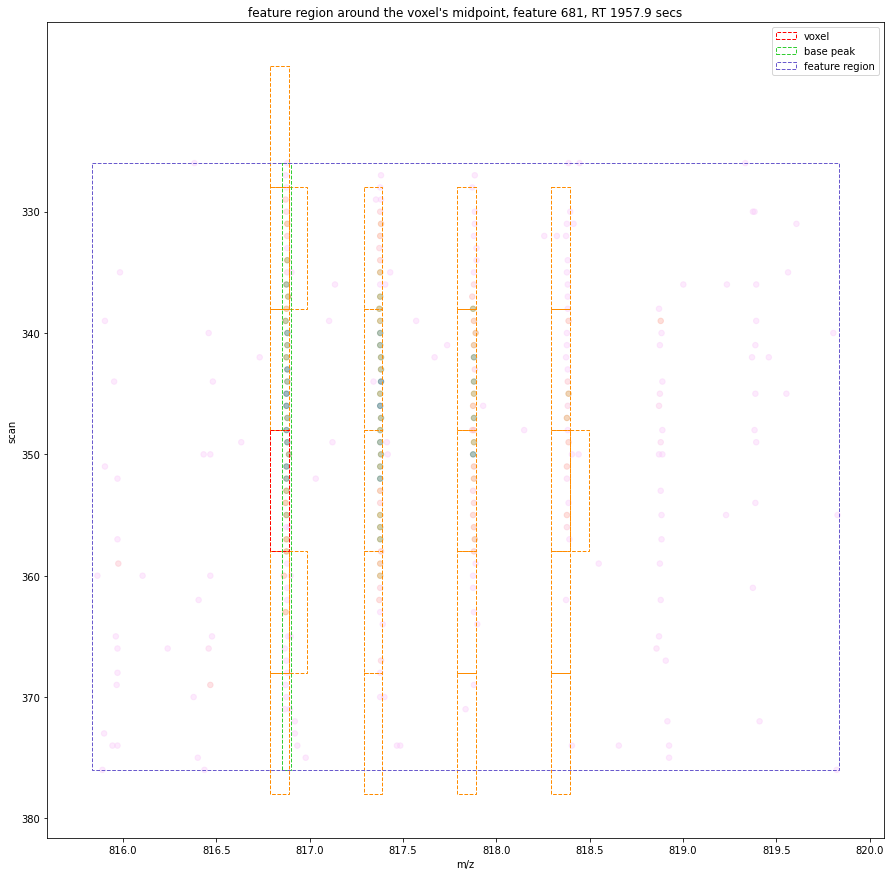

In [136]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(voxel_most_intense_frame_df.mz, voxel_most_intense_frame_df.scan, c=voxel_most_intense_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
# plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the affected voxels
for v in voxels:
    if (v['rt_lower'] <= selected_feature.rt_apex) and (v['rt_upper'] >= selected_feature.rt_apex):
        top_left = (v['mz_lower'],v['scan_lower'])
        width = v['mz_upper'] - v['mz_lower']
        height = v['scan_upper'] - v['scan_lower']
        cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='darkorange',facecolor='none')
        ax1.add_patch(cuboid_rect)
    
# draw the original voxel
top_left = (voxel_mz_lower,voxel_scan_lower)
width = voxel_mz_upper - voxel_mz_lower
height = voxel_scan_upper - voxel_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='red',facecolor='none',label='voxel')
ax1.add_patch(cuboid_rect)

# draw the base peak
top_left = (base_peak_mz_lower,base_peak_scan_lower)
width = base_peak_mz_upper - base_peak_mz_lower
height = base_peak_scan_upper - base_peak_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='limegreen',facecolor='none',label='base peak')
ax1.add_patch(cuboid_rect)

# draw the feature region for deconvolution
top_left = (feature_region_mz_lower,feature_region_scan_lower)
width = feature_region_mz_upper - feature_region_mz_lower
height = feature_region_scan_upper - feature_region_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(voxel_most_intense_frame_df.mz.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(voxel_most_intense_frame_df.scan.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [137]:
scan_df = pd.DataFrame(selected_feature.scan_df)

In [138]:
base_peak_mz_midpoint = base_peak_mz_lower + (base_peak_mz_upper-base_peak_mz_lower)/2

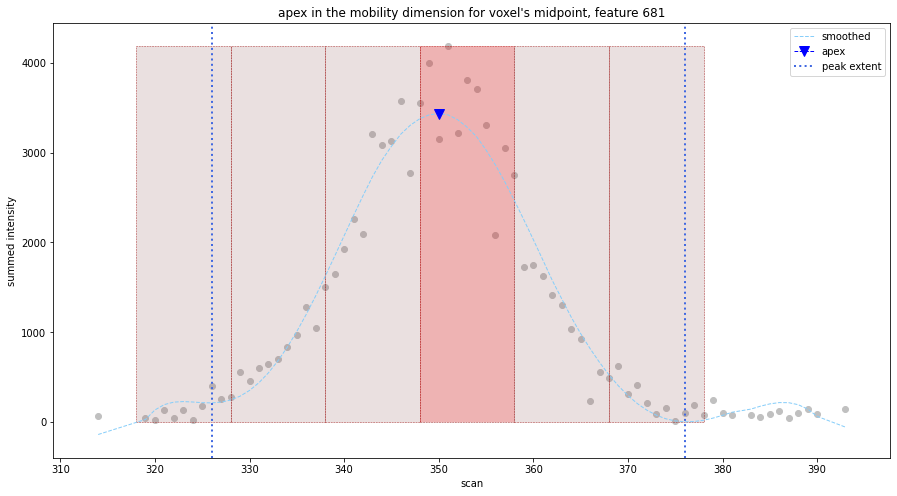

In [139]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# draw the affected voxels
for v in voxels:
    if (v['mz_lower'] <= base_peak_mz_midpoint) and (v['mz_upper'] >= base_peak_mz_midpoint) and (v['rt_lower'] <= selected_feature.rt_apex) and (v['rt_upper'] >= selected_feature.rt_apex):
        bottom_left = (v['scan_lower'],0)
        width = v['scan_upper'] - v['scan_lower']
        height = scan_df.intensity.max()
        cuboid_rect = patches.Rectangle(bottom_left,width,height,linewidth=0.5,linestyle='--',edgecolor='brown',facecolor=(0.6,0.4,0.4,0.2))
        ax1.add_patch(cuboid_rect)

# draw the original voxel
bottom_left = (selected_feature.voxel_metadata_d['scan_lower'],0)
width = selected_feature.voxel_metadata_d['scan_upper'] - selected_feature.voxel_metadata_d['scan_lower']
height = scan_df.intensity.max()
cuboid_rect = patches.Rectangle(bottom_left,width,height,linewidth=1.0,linestyle='--',edgecolor=None,facecolor=(1,0,0,0.2))
ax1.add_patch(cuboid_rect)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.scan_apex, scan_df[scan_df.scan==selected_feature.scan_apex].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the mobility dimension for voxel\'s midpoint, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

In [140]:
rt_df = pd.DataFrame(selected_feature.rt_df)

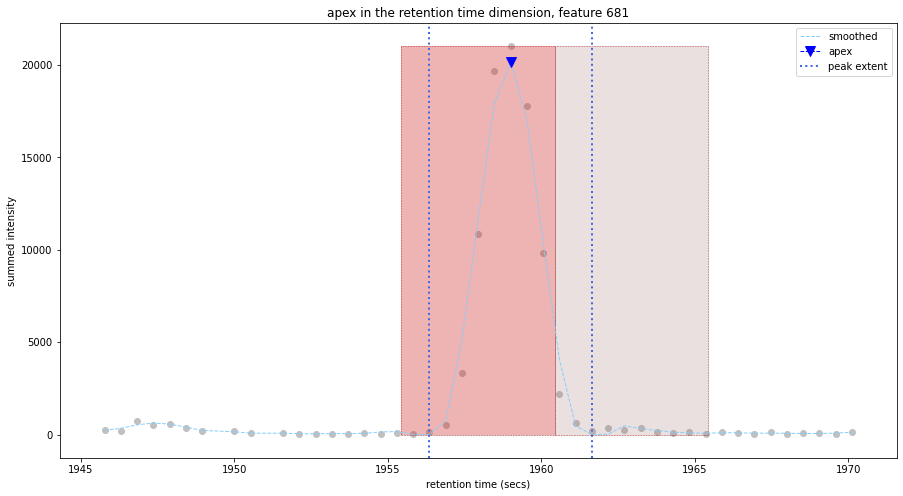

In [141]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# draw the affected voxels
for v in voxels:
    if (v['mz_lower'] <= base_peak_mz_midpoint) and (v['mz_upper'] >= base_peak_mz_midpoint) and (v['scan_lower'] <= selected_feature.scan_apex) and (v['scan_upper'] >= selected_feature.scan_apex):
        bottom_left = (v['rt_lower'],0)
        width = v['rt_upper'] - v['rt_lower']
        height = rt_df.intensity.max()
        cuboid_rect = patches.Rectangle(bottom_left,width,height,linewidth=0.5,linestyle='--',edgecolor='brown',facecolor=(0.6,0.4,0.4,0.2))
        ax1.add_patch(cuboid_rect)

# draw the original voxel
bottom_left = (selected_feature.voxel_metadata_d['rt_lower'],0)
width = selected_feature.voxel_metadata_d['rt_upper'] - selected_feature.voxel_metadata_d['rt_lower']
height = rt_df.intensity.max()
cuboid_rect = patches.Rectangle(bottom_left,width,height,linewidth=1.0,linestyle='--',edgecolor=None,facecolor=(1,0,0,0.2))
ax1.add_patch(cuboid_rect)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.clipped_filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.rt_apex, rt_df[rt_df.retention_time_secs==selected_feature.rt_apex].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the retention time dimension, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()